In [2]:
pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 9.9 MB/s eta 0:00:00


In [3]:
pip install praw pandas numpy scikit-learn nltk textblob joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 9.0 MB/s eta 0:00:00


In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
pip install praw pandas numpy scikit-learn nltk matplotlib wordcloud

                                                                                                  text  \
0  Our most-broken and least-understood rules is "helpers may not invite private contact as a first...   
1  Regular check-in post, with information about our rules and wikis Welcome to /r/depression's che...   
2  What's the point of life anyway? I asked myself this question since i was a little, i am gonna d...   
3  I get so depressed every time I hear people talk about sex Any time people like my coworkers or ...   
4  I don't understand how people don't want to kill themselves I kind of just want to die so bad an...   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  

Preprocessing text data...
                                                                                                  text  \
0  Our most-broken and least-understood rules is "helpers may not invite private contact as a first...   
1  Regular check-in post, with information about our rule

<ipython-input-21-678f10de2989>:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text'].fillna('', inplace=True)


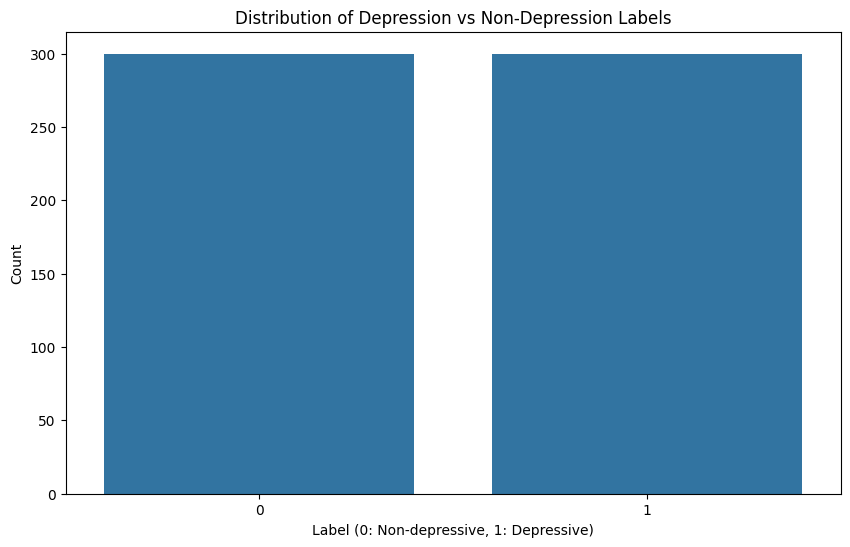

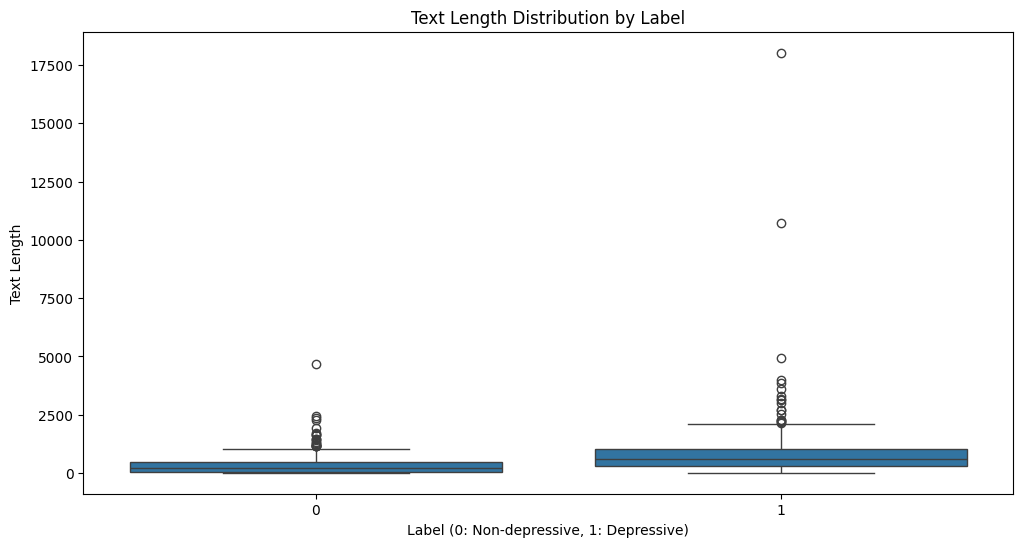

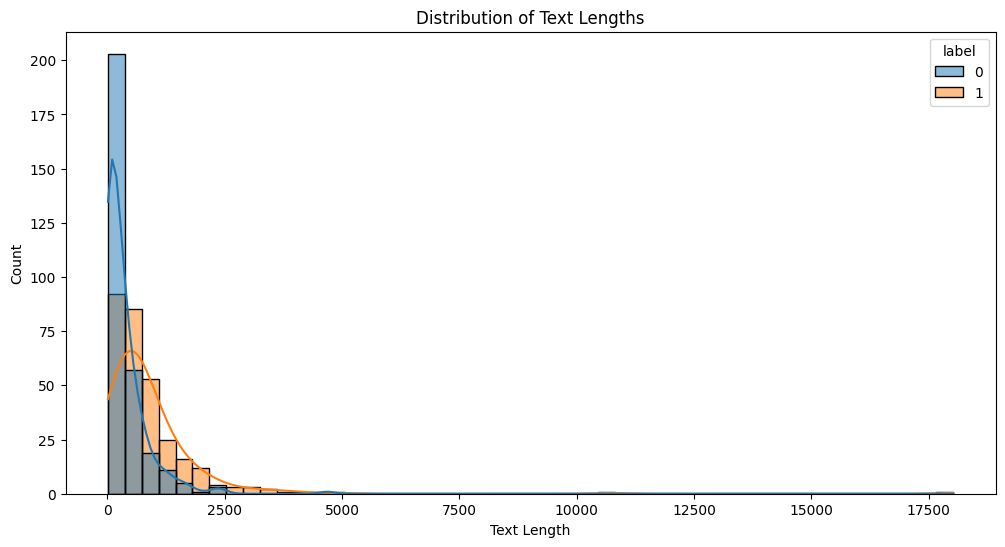

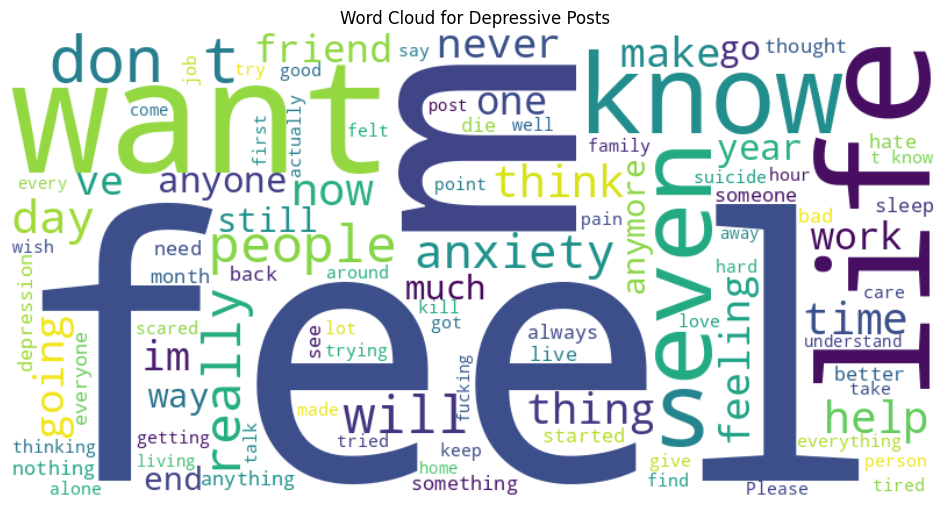

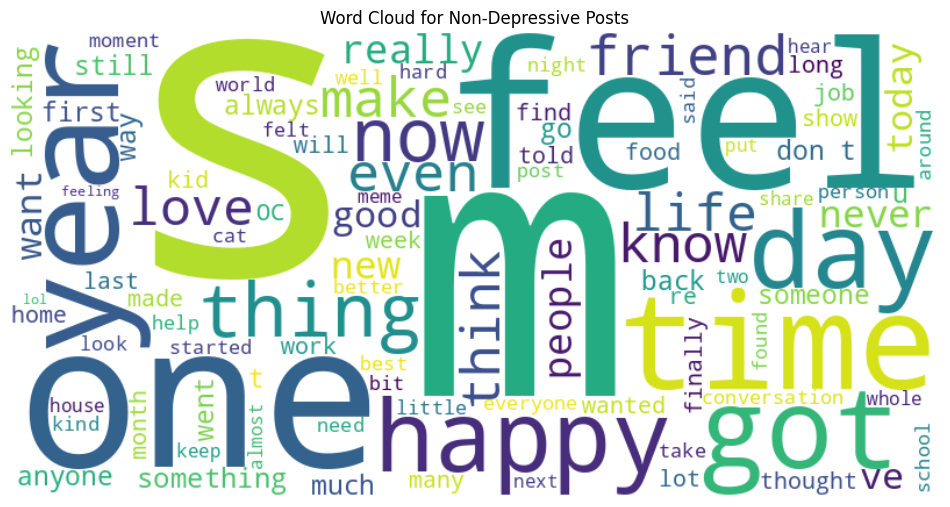

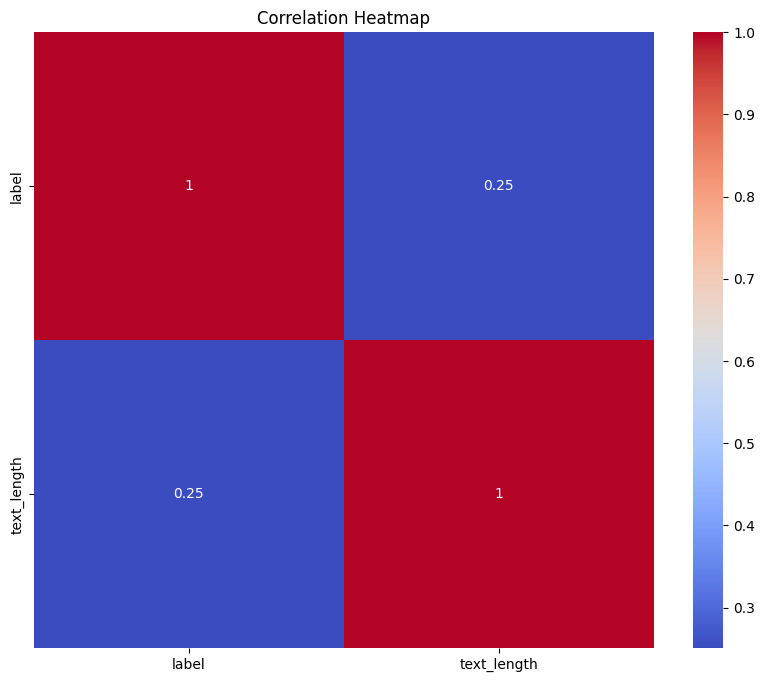


Extracting features...

Training and evaluating models...
Logistic Regression Accuracy: 0.8917
K-Nearest Neighbors Accuracy: 0.8083
Decision Tree Accuracy: 0.7667
Support Vector Machine Accuracy: 0.8917
Naive Bayes Accuracy: 0.8250
Multi-Layer Perceptron Accuracy: 0.8667
Voting Classifier Accuracy: 0.8917


In [21]:
import asyncpraw
import pandas as pd
import numpy as np
import asyncio
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Step 1: Data Collection
async def collect_reddit_data():
    reddit = asyncpraw.Reddit(
        client_id="xCN2vTxnfk1hwigVZFozRw",
        client_secret="ZZuEd6iRja26iOsYbYxETa6ya-h2FA",
        user_agent="u/Easy_Cook_7412"
    )

    depressive_subreddits = ['depression', 'SuicideWatch', 'anxiety']
    non_depressive_subreddits = ['happy', 'CasualConversation', 'wholesomememes']

    posts = []

    for subreddit in depressive_subreddits:
        subreddit_instance = await reddit.subreddit(subreddit)  # Await the subreddit instance
        async for post in subreddit_instance.hot(limit=100):  # Use the instance to access hot posts
            posts.append({'text': post.title + ' ' + post.selftext, 'label': 1})

    for subreddit in non_depressive_subreddits:
        subreddit_instance = await reddit.subreddit(subreddit)  # Await the subreddit instance
        async for post in subreddit_instance.hot(limit=100):  # Use the instance to access hot posts
            posts.append({'text': post.title + ' ' + post.selftext, 'label': 0})

    df = pd.DataFrame(posts)
    pd.set_option("display.max_colwidth", 100)
    return df

# Step 2: Data Preprocessing
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Step 3: Exploratory Data Analysis

# Enhanced EDA function
def perform_eda(df):
    print("Performing Exploratory Data Analysis...")
    print("\n1. Basic Dataset Information:")
    print("-" * 50)
    print(f"Dataset Shape: {df.shape}")
    print("\nDataset Info:")
    print(df.info())

    print("\n2. Checking for NULL values:")
    print("-" * 50)
    null_counts = df.isnull().sum()
    print(null_counts)

    # Handle NULL values
    df['text'].fillna('', inplace=True)
    print("\nNULL values have been handled.")

    print("\n3. Basic Statistical Analysis:")
    print("-" * 50)
    # Calculate text lengths
    df['text_length'] = df['text'].apply(len)
    print("\nText Length Statistics:")
    print(df['text_length'].describe())

    # Detect outliers using IQR method
    Q1 = df['text_length'].quantile(0.25)
    Q3 = df['text_length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
    print(f"\nNumber of outliers detected: {len(outliers)}")

    # Visualizations
    print("\n4. Creating Visualizations...")
    print("-" * 50)

    # 1. Distribution of Labels
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=df)
    plt.title('Distribution of Depression vs Non-Depression Labels')
    plt.xlabel('Label (0: Non-depressive, 1: Depressive)')
    plt.ylabel('Count')
    plt.show()

    # 2. Text Length Distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='label', y='text_length', data=df)
    plt.title('Text Length Distribution by Label')
    plt.xlabel('Label (0: Non-depressive, 1: Depressive)')
    plt.ylabel('Text Length')
    plt.show()

    # 3. Text Length Histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.show()

    # 4. Word Cloud for Depressive Posts
    depressive_text = ' '.join(df[df['label'] == 1]['text'])
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(depressive_text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Depressive Posts')
    plt.show()

    # 5. Word Cloud for Non-Depressive Posts
    non_depressive_text = ' '.join(df[df['label'] == 0]['text'])
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(non_depressive_text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Non-Depressive Posts')
    plt.show()

    # 6. Correlation Heatmap for numerical features
    numerical_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(10, 8))
    sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
    return df


# Step 4: Feature Extraction
def extract_features(df):
    tfidf = TfidfVectorizer(ngram_range=(1, 2),max_features=5000)
    X = tfidf.fit_transform(df['text'])
    y = df['label']
    return X, y

# Step 5: Model Training and Testing
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Logistic Regression': LogisticRegression(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Support Vector Machine': SVC(probability=True),
        'Naive Bayes': MultinomialNB(),
        'Multi-Layer Perceptron': MLPClassifier()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")

    # Ensemble Learning: Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[(name, model) for name, model in models.items()],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)
    y_pred_voting = voting_clf.predict(X_test)
    voting_accuracy = accuracy_score(y_test, y_pred_voting)
    print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

# Main function
async def main():
    # 1. Data Collection
    print("Collecting data from Reddit...")
    df = await collect_reddit_data()
    print(df.head())
    # 2. Data Preprocessing
    print("\nPreprocessing text data...")
    df['processed_text'] = df['text'].apply(preprocess_text)
    print(df.head())
    # 3. Perform EDA
    df = perform_eda(df)

    # 4. Feature Extraction
    print("\nExtracting features...")
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(df['processed_text'])
    y = df['label']

    # 5. Model Training and Evaluation
    print("\nTraining and evaluating models...")
    train_and_evaluate_models(X, y)

# Run the main function
if __name__ == "__main__":
    asyncio.run(main())


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l


Preprocessing text data...
Performing Exploratory Data Analysis...

1. Basic Dataset Information:
--------------------------------------------------
Dataset Shape: (600, 3)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            600 non-null    object
 1   label           600 non-null    int64 
 2   processed_text  600 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.2+ KB
None

2. Checking for NULL values:
--------------------------------------------------
text              0
label             0
processed_text    0
dtype: int64

NULL values have been handled.

3. Basic Statistical Analysis:
--------------------------------------------------

Text Length Statistics:
count      600.000000
mean       622.530000
std       1051.856882
min         11.000000
25%        150.750000
50%        375.500000
75%  

<ipython-input-20-ee55a2490fad>:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text'].fillna('', inplace=True)


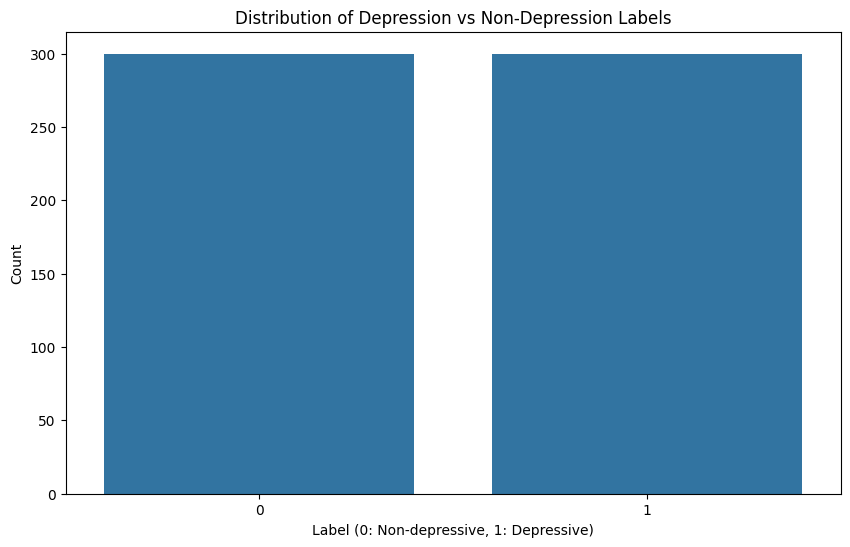

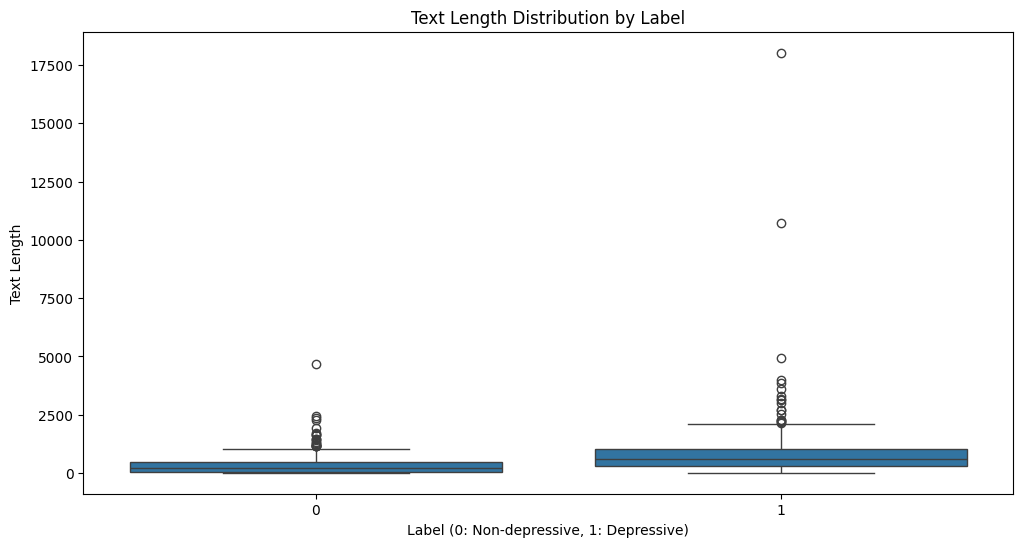

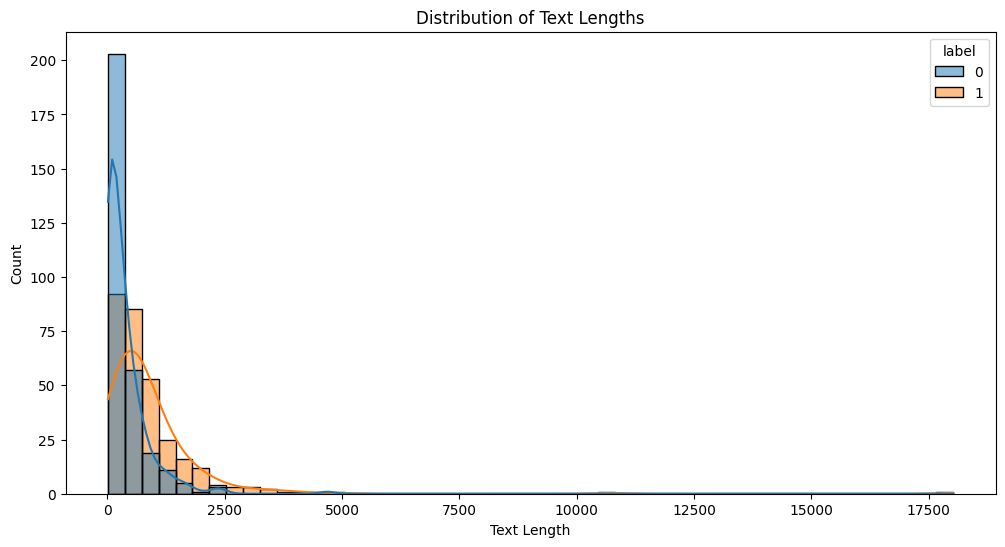

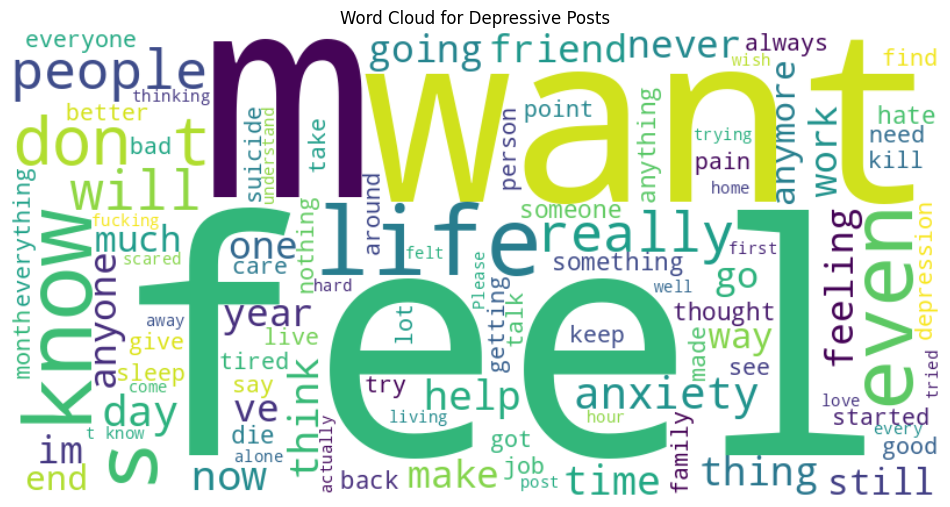

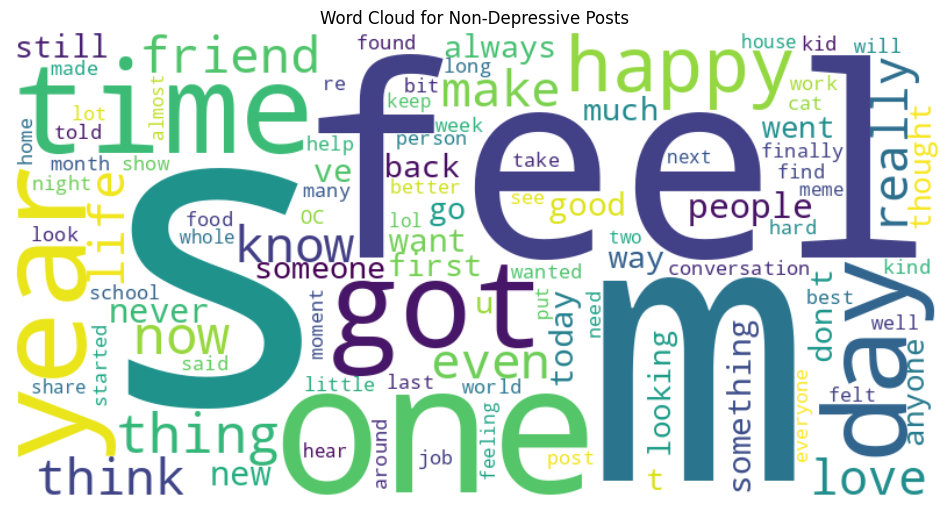

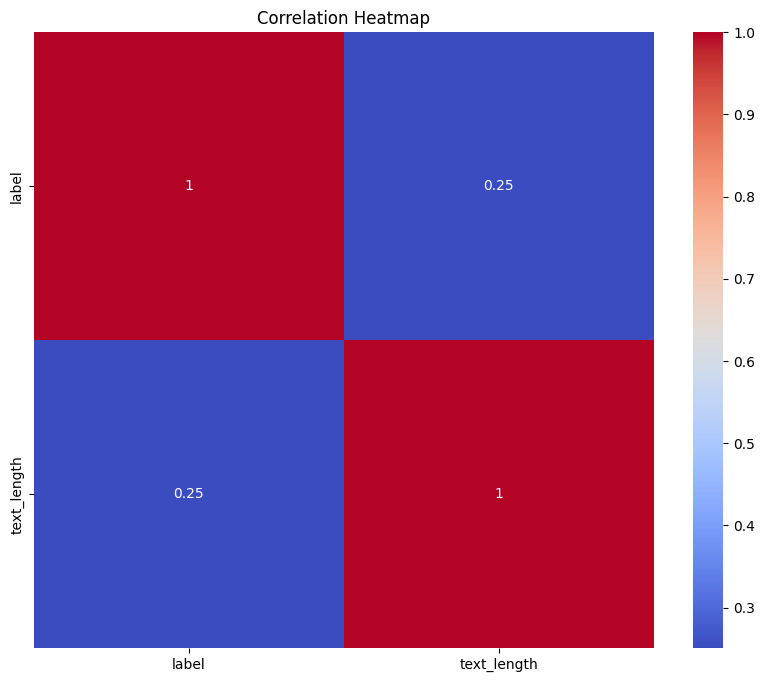


Extracting features...

Training and evaluating models...
Logistic Regression Accuracy: 0.8917
K-Nearest Neighbors Accuracy: 0.8167
Decision Tree Accuracy: 0.7333
Support Vector Machine Accuracy: 0.9000
Naive Bayes Accuracy: 0.8333
Multi-Layer Perceptron Accuracy: 0.8917
Blending Classifier Accuracy: 0.9000


In [20]:
import praw
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Step 1: Data Collection
def collect_reddit_data():
    # Replace with your Reddit API credentials
    reddit = praw.Reddit(
        client_id="xCN2vTxnfk1hwigVZFozRw",
        client_secret="ZZuEd6iRja26iOsYbYxETa6ya-h2FA",
        user_agent="u/Easy_Cook_7412"
    )

    depressive_subreddits = ['depression', 'SuicideWatch', 'anxiety']
    non_depressive_subreddits = ['happy', 'CasualConversation', 'wholesomememes']

    posts = []

    for subreddit in depressive_subreddits:
        for post in reddit.subreddit(subreddit).hot(limit=100):
            posts.append({'text': post.title + ' ' + post.selftext, 'label': 1})

    for subreddit in non_depressive_subreddits:
        for post in reddit.subreddit(subreddit).hot(limit=100):
            posts.append({'text': post.title + ' ' + post.selftext, 'label': 0})

    df = pd.DataFrame(posts)
    return df

# Step 2: Data Preprocessing
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Step 3: Exploratory Data Analysis
import praw
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Enhanced EDA function
def perform_eda(df):
    print("Performing Exploratory Data Analysis...")
    print("\n1. Basic Dataset Information:")
    print("-" * 50)
    print(f"Dataset Shape: {df.shape}")
    print("\nDataset Info:")
    print(df.info())

    print("\n2. Checking for NULL values:")
    print("-" * 50)
    null_counts = df.isnull().sum()
    print(null_counts)

    # Handle NULL values
    df['text'].fillna('', inplace=True)
    print("\nNULL values have been handled.")

    print("\n3. Basic Statistical Analysis:")
    print("-" * 50)
    # Calculate text lengths
    df['text_length'] = df['text'].apply(len)
    print("\nText Length Statistics:")
    print(df['text_length'].describe())

    # Detect outliers using IQR method
    Q1 = df['text_length'].quantile(0.25)
    Q3 = df['text_length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
    print(f"\nNumber of outliers detected: {len(outliers)}")

    # Visualizations
    print("\n4. Creating Visualizations...")
    print("-" * 50)

    # 1. Distribution of Labels
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=df)
    plt.title('Distribution of Depression vs Non-Depression Labels')
    plt.xlabel('Label (0: Non-depressive, 1: Depressive)')
    plt.ylabel('Count')
    plt.show()

    # 2. Text Length Distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='label', y='text_length', data=df)
    plt.title('Text Length Distribution by Label')
    plt.xlabel('Label (0: Non-depressive, 1: Depressive)')
    plt.ylabel('Text Length')
    plt.show()

    # 3. Text Length Histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.show()

    # 4. Word Cloud for Depressive Posts
    depressive_text = ' '.join(df[df['label'] == 1]['text'])
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(depressive_text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Depressive Posts')
    plt.show()

    # 5. Word Cloud for Non-Depressive Posts
    non_depressive_text = ' '.join(df[df['label'] == 0]['text'])
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(non_depressive_text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Non-Depressive Posts')
    plt.show()

    # 6. Correlation Heatmap for numerical features
    numerical_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(10, 8))
    sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
    return df


# Step 4: Feature Extraction
def extract_features(df):
    tfidf = TfidfVectorizer(ngram_range=(1, 2),max_features=5000)
    X = tfidf.fit_transform(df['text'])
    y = df['label']
    return X, y

# Step 5: Model Training and Testing
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Logistic Regression': LogisticRegression(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Support Vector Machine': SVC(probability=True),
        'Naive Bayes': MultinomialNB(),
        'Multi-Layer Perceptron': MLPClassifier()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")

    # Blending Classifier
    # Create a new dataset for the meta-model
    base_model_predictions = np.zeros((X_test.shape[0], len(models)))

    for i, (name, model) in enumerate(models.items()):
        # Use the base model to predict on the training set
        model.fit(X_train, y_train)
        base_model_predictions[:, i] = model.predict(X_test)

    # Train a meta-model on the predictions of the base models
    meta_model = LogisticRegression()  # You can choose any model here
    meta_model.fit(base_model_predictions, y_test)
    # Make predictions with the blending model
    blended_predictions = meta_model.predict(base_model_predictions)
    blended_accuracy = accuracy_score(y_test, blended_predictions)
    print(f"Blending Classifier Accuracy: {blended_accuracy:.4f}")

def main():
    # 1. Data Collection
    print("Collecting data from Reddit...")
    df = collect_reddit_data()

    # 2. Data Preprocessing
    print("\nPreprocessing text data...")
    df['processed_text'] = df['text'].apply(preprocess_text)

    # 3. Perform EDA
    df = perform_eda(df)

    # 4. Feature Extraction
    print("\nExtracting features...")
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(df['processed_text'])
    y = df['label']

    # 5. Model Training and Evaluation
    print("\nTraining and evaluating models...")
    train_and_evaluate_models(X, y)

if __name__ == "__main__":
    main()